# Applied Data Science - Capstone Project

## Install required Python packages

In [87]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium --yes 
!conda install -c conda-forge pyquery --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/ibm/conda/miniconda3

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    geopy-1.16.0               |             py_0          50 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          82 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.16.0-py_0 conda-forge


geographiclib-1.49   | 32 KB     | ##################################### | 100% 
geopy-1.16.0         | 50 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  e

## Get Wiki page containing Toronto Boroughs/Neighborhoods
### Note: using pandas.io.hmtl to get the wiki table into pandas DataFrame

In [204]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
wikitables = soup.find_all('table') 
Toronto = pd.read_html(str(wikitables[0]), index_col=None, header=0)[0]
Toronto.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [205]:
# TO VERIFY THAT BOTH METHODS PRODUCE SIMILAR DIMENSIONS
Toronto.shape

(289, 3)

## Alternative way to read in the content and produce a dataframe using pandas.io.html
### Note: Results are consistent between the two methods

In [22]:
import requests
import numpy as np
import pandas as pd
from pandas.io.html import read_html

# Define the wiki page url var
WIKI_URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
# Issue HTTP request to get the URL content
req = requests.get(WIKI_URL)
# Use pandas read_html to read in the content
wikitables = read_html(WIKI_URL, index_col=None, header=0, attrs={"class":["sortable","wikitable"]})
# Get pandas dataframe
Toronto = wikitables[0]
Toronto.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [207]:
# TO VERIFY THAT BOTH METHODS PRODUCE SIMILAR DIMENSIONS
Toronto.shape

(289, 3)

## Data cleaning

In [23]:
# Empty entries to np.nan to drop them in the next step
Toronto['Borough'].replace('', np.nan, inplace=True)
# Drop np.nan to remove rows not containing meaningful data
Toronto.dropna(subset=['Borough'], inplace=True)
# Leave behind rows containing 'Not assigned' in 'Borough'
Toronto = Toronto[Toronto['Borough'] != 'Not assigned']

## Data processing - 'Not assigned' to value

In [24]:
# Iterate over the dataframe and fix 'Not assigned' for column 'Neighborhood'
for i, _ in Toronto.iterrows():
    if Toronto.loc[i]['Neighbourhood'] == 'Not assigned': Toronto.loc[i]['Neighborhood'] = Toronto.loc[i]['Borough']

## Dataframe shape

In [25]:
# Check datafame shape
Toronto.shape

(212, 3)

## Number of rows in the dataframe

In [26]:
# Print the number of rows in the dataframe
print('Number of rows in Toronto dataframe: {}'.format(Toronto.shape[0]))

Number of rows in Toronto dataframe: 212


In [32]:
!conda install -c conda-forge geocoder --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/ibm/conda/miniconda3

  added / updated specs: 
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ratelim-0.1.6              |           py35_0           5 KB  conda-forge
    orderedset-2.0             |           py35_0         685 KB  conda-forge
    certifi-2018.8.24          |           py35_1         138 KB  conda-forge
    geocoder-1.38.1            |             py_0          52 KB  conda-forge
    ca-certificates-2018.8.24  |       ha4d7672_0         136 KB  conda-forge
    openssl-1.0.2p             |       h470a237_0         3.5 MB  conda-forge
    conda-4.5.11               |           py35_0         636 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.1 MB

The following NEW packages will be INS

## API compensator - at times geocoder.google returns None for the same postal code
### Create a dictionary of all the postal codes to add to the dictionary at the next step

In [27]:
TPS = Toronto['Postcode'].unique()
len(TPS)

103

## Get offline cache to support throttled Geocoder API

In [28]:
!wget -q --no-check-certificate -O 'latitude.pickle' 'https://docs.google.com/uc?export=download&id=1PdEOkPErrpBtDgSlDwczIv_KLlpY-YcO'
!wget -q --no-check-certificate -O 'longitude.pickle' 'https://docs.google.com/uc?export=download&id=1XujA04dCARQnlxu-X2ItOVcYQz0MMQh9'

In [29]:
!ls -l *.pickle

-rw-r--r-- 1 spark spark 1965 Sep 12 18:44 latitude.pickle
-rw-r--r-- 1 spark spark 1965 Sep 12 18:44 longitude.pickle


In [30]:
import pickle

with open('latitude.pickle', 'rb') as flat:
    latitude = pickle.load(flat)
with open('longitude.pickle', 'rb') as flon:
    longitude = pickle.load(flon)

In [33]:
import geocoder
import time

for postcode in TPS:
    # When offline cache is available use it to avoid Geocoder Google API throttling
    if postcode in latitude.keys(): 
        continue
    while True:
        g = geocoder.google('{}, Toronto, Ontario'.format(postcode))
        lat_lng_coords = g.latlng
        if lat_lng_coords == None:
            print('Trottled response to {}'.format(postcode))
            time.sleep(5)
            continue
        break
    
    if lat_lng_coords != None:
        latitude[postcode] = lat_lng_coords[0]
        longitude[postcode] = lat_lng_coords[1]
print('Successfully populated geo locations')

Successfully populated geo locations


In [34]:
lat = []
lon = []
for i, _ in Toronto.iterrows():
    lat.append(latitude[Toronto.loc[i]['Postcode']])
    lon.append(longitude[Toronto.loc[i]['Postcode']])
                        

In [35]:
Toronto = Toronto.assign(Latitude = lat, Longitude=lon)
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
5,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
6,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [36]:
Toronto = Toronto.reset_index(drop=True)
Toronto.to_csv('Toronto.csv')
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


## Additional imports

In [274]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Import Demographics Data

### Pull the data from Wikipedia

In [43]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

res = requests.get("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods")
soup = BeautifulSoup(res.content,'lxml')
wikitables = soup.find_all('table') 
Toronto_Demographics = pd.read_html(str(wikitables[1]), index_col=None, header=0)[0]

### Post process the dataframe Toronto_Demographics

In [44]:
columns_to_drop = [
    'FM', 
    'Census Tracts', 
    '% Change in Population since 2001', 
    'Land area (km2)', 
    'Transit Commuting\xa0%', 
    '% Renters', 
    'Second most common language (after English) by name', 
    'Map'
]

Toronto_Demographics.drop(columns=columns_to_drop, inplace=True)

Toronto_Demographics = Toronto_Demographics.rename(columns={'Second most common language (after English) by percentage':'ESL'})
Toronto_Demographics = Toronto_Demographics.rename(columns={'Name':'Neighbourhood'})
Toronto_Demographics.drop([0], inplace=True)

Toronto_Demographics.head()
Toronto_Demographics['Percentage'] = Toronto_Demographics.apply (lambda row: row['ESL'].split('% ')[0],axis=1)
Toronto_Demographics['Language'] = Toronto_Demographics.apply (lambda row: row['ESL'].split('% ')[1],axis=1)
Toronto_Demographics.drop(columns=['ESL'], inplace=True)

### Show post processed result on Toronto_Demographics

In [45]:
Toronto_Demographics.head()

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
1,Agincourt,44577,3580,25750,19.3,Cantonese
2,Alderwood,11656,2360,35239,06.2,Polish
3,Alexandra Park,4355,13609,19687,17.9,Cantonese
4,Allenby,2513,4333,245592,01.4,Russian
5,Amesbury,17318,4934,27546,06.1,Spanish


### Explore the demographics data for the city of Toronto

In [46]:
list_of_neighbourhoods = Toronto_Demographics['Neighbourhood'].values.tolist()

In [47]:
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


### Check the neighbourhoods not present in the dataframe Toronto and remove them from the dataframe Toronto_Demographics

In [48]:
list_missing_neigh = []
for neigh in list_of_neighbourhoods:
    if neigh not in Toronto['Neighbourhood'].values and neigh not in Toronto['Borough']:
        list_missing_neigh.append(neigh)
list_missing_neigh

['Alexandra Park',
 'Allenby',
 'Amesbury',
 'Armour Heights',
 'Banbury',
 'Bay Street Corridor',
 'Bayview Woods – Steeles',
 'Bendale',
 'Bloor West Village',
 'Bracondale Hill',
 'Branson',
 'Bridle Path',
 'Caribou Park',
 'Carleton Village',
 'Casa Loma',
 'Centennial',
 'Chaplin Estates',
 'Christie Pits',
 'Clairville',
 'Corktown',
 'Crescent Town',
 'Cricket Club',
 'Davenport',
 'Discovery District',
 'Distillery District/West Don Lands',
 'Don Mills',
 'Don Valley Village',
 'Dovercourt Park',
 'Downsview',
 'Dufferin Grove',
 'Earlscourt',
 'East Danforth',
 'Eatonville',
 'Eglinton East',
 'Elia (Jane and Finch)',
 'Fairbank',
 'Fashion District',
 'Financial District',
 'Forest Hill',
 'Fort York/Liberty Village',
 'Glen Park',
 "Governor's Bridge/Bennington Heights",
 'Graydon Hall',
 'Guildwood',
 'Harbord Village',
 'Harbourfront / CityPlace',
 'Harwood',
 'High Park North',
 'Hillcrest',
 'Hoggs Hollow',
 'Humber Heights',
 'Humber Valley Village',
 'Humbermede',
 'H

In [61]:
Toronto_Demographics = Toronto_Demographics[~Toronto_Demographics.Neighbourhood.isin(list_missing_neigh)]

In [63]:
Toronto_Demographics.reset_index(drop=True)

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
0,Agincourt,44577,3580,25750,19.3,Cantonese
1,Alderwood,11656,2360,35239,06.2,Polish
2,Bathurst Manor,14945,3187,34169,09.5,Russian
3,Bayview Village,12280,2966,46752,08.4,Cantonese
4,Bedford Park,13749,6057,80827,00.7,Greek
5,Birch Cliff,12266,3525,48965,00.9,Unspecified Chinese
6,Brockton,9039,8217,27260,19.9,Portuguese
7,Cabbagetown,11120,7943,50398,01.6,Unspecified Chinese
8,Church and Wellesley,13397,24358,37653,01.8,Spanish
9,Clairlea,11104,3102,33392,04.3,Filipino


### Drop entries from the dataframe Toronto that are not in the dataframe Toronto_Demographics

In [64]:
list_exist_neigh_dem = Toronto_Demographics['Neighbourhood'].values.tolist()

In [67]:
Toronto = Toronto[Toronto.Neighbourhood.isin(list_exist_neigh_dem)]
Toronto.reset_index(drop=True)
Toronto.shape

(77, 5)

In [66]:
Toronto_Demographics.shape

(76, 6)

In [68]:
Toronto_Demographics.head()

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
1,Agincourt,44577,3580,25750,19.3,Cantonese
2,Alderwood,11656,2360,35239,06.2,Polish
8,Bathurst Manor,14945,3187,34169,09.5,Russian
10,Bayview Village,12280,2966,46752,08.4,Cantonese
12,Bedford Park,13749,6057,80827,00.7,Greek


In [69]:
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
4,M6A,North York,Lawrence Heights,43.718518,-79.464763
5,M6A,North York,Lawrence Manor,43.718518,-79.464763
8,M1B,Scarborough,Rouge,43.806686,-79.194353


### Merge the two dataframes to create a workabable dataframe - Toronto_Merged

In [82]:
Toronto_Merged = pd.merge(Toronto, Toronto_Demographics, on='Neighbourhood')

In [83]:
Toronto_Merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M3A,North York,Parkwoods,43.753259,-79.329656,26533,5349,34811,03.4,Unspecified Chinese
1,M4A,North York,Victoria Village,43.725882,-79.315572,17047,3612,29657,03.2,Urdu
2,M6A,North York,Lawrence Heights,43.718518,-79.464763,3769,1178,29867,15.0,Italian
3,M6A,North York,Lawrence Manor,43.718518,-79.464763,13750,6425,36361,07.2,Filipino
4,M1B,Scarborough,Rouge,43.806686,-79.194353,22724,791,29230,15.6,Tamil


### Remove duplicate entries from the dataframe Toronto_Merged

In [84]:
Toronto_Merged.drop_duplicates(keep='first', inplace=True)

In [85]:
Toronto_Merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M3A,North York,Parkwoods,43.753259,-79.329656,26533,5349,34811,03.4,Unspecified Chinese
1,M4A,North York,Victoria Village,43.725882,-79.315572,17047,3612,29657,03.2,Urdu
2,M6A,North York,Lawrence Heights,43.718518,-79.464763,3769,1178,29867,15.0,Italian
3,M6A,North York,Lawrence Manor,43.718518,-79.464763,13750,6425,36361,07.2,Filipino
4,M1B,Scarborough,Rouge,43.806686,-79.194353,22724,791,29230,15.6,Tamil
5,M1B,Scarborough,Malvern,43.806686,-79.194353,44324,5003,25677,12.2,Tamil
6,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,8240,15846,37614,03.0,Unspecified Chinese
7,M9B,Etobicoke,Princess Gardens,43.650943,-79.554724,9288,2249,80607,02.4,Korean
8,M9B,Etobicoke,West Deane Park,43.650943,-79.554724,4395,2063,41582,02.3,Ukrainian
9,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12853,2505,33640,05.1,Tamil


In [90]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
T_lat = location.latitude
T_lon = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(T_lat, T_lon))

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/geopy/geocoders/osm.py:138: UserWarning: Using Nominatim with the default "geopy/1.16.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto, ON, Canada are 43.653963, -79.387207.


# Create a map of Toronto with neighbourhoods

In [92]:
T_map = folium.Map(location=[T_lat, T_lon], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Borough'], Toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(T_map)  
    
T_map

# Prepare Foursquare credentials

In [93]:
CLIENT_ID = '0C4ANZOALOMRDOJZU2BUYUKB2LOF3N5ADH4A3WJ3UDS3YIJD'
CLIENT_SECRET = 'MIJAG0GZX3JF2RXLGPCOOH25QZ3NBF2MLFYQJUG2DD5LCNM3'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0C4ANZOALOMRDOJZU2BUYUKB2LOF3N5ADH4A3WJ3UDS3YIJD
CLIENT_SECRET:MIJAG0GZX3JF2RXLGPCOOH25QZ3NBF2MLFYQJUG2DD5LCNM3


## Create a new dataframe targeting a specific ethnic group - Ukrainian

In [100]:
df_uk = Toronto_Merged[Toronto_Merged.Language == 'Ukrainian']
df_uk = df_uk.sort_values(by=['Percentage','Population'], ascending=False)
df_uk.reset_index(drop=True)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M9P,Etobicoke,Westmount,43.696319,-79.532242,5857,5932,35183,10.6,Ukrainian
1,M9B,Etobicoke,West Deane Park,43.650943,-79.554724,4395,2063,41582,02.3,Ukrainian
2,M6S,West Toronto,Runnymede,43.651571,-79.484450,4382,5155,42635,02.2,Ukrainian
3,M8X,Etobicoke,The Kingsway,43.653654,-79.506944,8780,3403,110944,01.8,Ukrainian


### Get a neighbourhood with the highest number of people with Ukrainian background

In [101]:
uk_lat = df_uk['Latitude'].values[0] # neighborhood latitude value
uk_lon = df_uk['Longitude'].values[0] # neighborhood longitude value
uk_name = df_uk['Neighbourhood'].values[0] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(uk_name, 
                                                               uk_lat, 
                                                               uk_lon))

Latitude and longitude values of Westmount are 43.696319, -79.5322424.


### Prepare Foursquare URL

In [102]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    uk_lat, 
    uk_lon, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=0C4ANZOALOMRDOJZU2BUYUKB2LOF3N5ADH4A3WJ3UDS3YIJD&client_secret=MIJAG0GZX3JF2RXLGPCOOH25QZ3NBF2MLFYQJUG2DD5LCNM3&v=20180605&ll=43.696319,-79.5322424&radius=500&limit=100'

### Issue a Foursquare request

In [103]:
results = requests.get(url).json()
# results
if results != None:
    print("Request successfully processed")

Request successfully processed


In [104]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [105]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Starbucks,Coffee Shop,43.696249,-79.533117
1,Mayflower Chinese Food,Chinese Restaurant,43.692753,-79.531566
2,Pizza Hut,Pizza Place,43.696431,-79.533233
3,Subway,Sandwich Place,43.692927,-79.531471
4,Pizza Nova,Pizza Place,43.692817,-79.531570


In [106]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

7 venues were returned by Foursquare.


In [107]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [110]:
# type your answer here
uk_venues = getNearbyVenues(names=df_uk['Neighbourhood'],
                                   latitudes=df_uk['Latitude'],
                                   longitudes=df_uk['Longitude']
                                  )

Westmount
West Deane Park
Runnymede
The Kingsway


In [111]:
print(uk_venues.shape)
uk_venues.head()

(44, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Westmount,43.696319,-79.532242,Starbucks,43.696249,-79.533117,Coffee Shop
1,Westmount,43.696319,-79.532242,Mayflower Chinese Food,43.692753,-79.531566,Chinese Restaurant
2,Westmount,43.696319,-79.532242,Pizza Hut,43.696431,-79.533233,Pizza Place
3,Westmount,43.696319,-79.532242,Subway,43.692927,-79.531471,Sandwich Place
4,Westmount,43.696319,-79.532242,Pizza Nova,43.692817,-79.531570,Pizza Place


### Get count of venues in the neighbourhoods with the highest population of Ukrainians

In [112]:
uk_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Runnymede,35,35,35,35,35,35
The Kingsway,1,1,1,1,1,1
West Deane Park,1,1,1,1,1,1
Westmount,7,7,7,7,7,7


In [113]:
print('There are {} uniques categories.'.format(len(uk_venues['Venue Category'].unique())))

There are 31 uniques categories.


### Perform one-hot encoding on the venues

In [114]:
# one hot encoding
uk_onehot = pd.get_dummies(uk_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
uk_onehot['Neighborhood'] = uk_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [uk_onehot.columns[-1]] + list(uk_onehot.columns[:-1])
uk_onehot = uk_onehot[fixed_columns]

uk_onehot.head()

,Neighborhood,Bank,Bar,Bookstore,Burrito Place,Café,Chinese Restaurant,Coffee Shop,Dessert Shop,Diner,Falafel Restaurant,Fish & Chips Shop,Food,French Restaurant,Gastropub,Gourmet Shop,Gym,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Pharmacy,Pizza Place,Playground,Pub,Restaurant,River,Sandwich Place,Smoothie Shop,Sushi Restaurant,Tea Room,Vegetarian / Vegan Restaurant
0,Westmount,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Westmount,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Westmount,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Westmount,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Westmount,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [115]:
uk_onehot.shape

(44, 32)

### Group the venues by neighbourhoods with Ukrainians

In [116]:
uk_grouped = uk_onehot.groupby('Neighborhood').mean().reset_index()
uk_grouped

,Neighborhood,Bank,Bar,Bookstore,Burrito Place,Café,Chinese Restaurant,Coffee Shop,Dessert Shop,Diner,Falafel Restaurant,Fish & Chips Shop,Food,French Restaurant,Gastropub,Gourmet Shop,Gym,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Pharmacy,Pizza Place,Playground,Pub,Restaurant,River,Sandwich Place,Smoothie Shop,Sushi Restaurant,Tea Room,Vegetarian / Vegan Restaurant
0,Runnymede,0.028571,0.028571,0.028571,0.028571,0.085714,0.000000,0.085714,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.000000,0.057143,0.028571,0.028571,0.085714,0.000000,0.028571,0.028571,0.0,0.028571,0.028571,0.057143,0.028571,0.028571
1,The Kingsway,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,West Deane Park,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,Westmount,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.285714,0.142857,0.000000,0.000000,0.0,0.142857,0.000000,0.000000,0.000000,0.000000


In [117]:
uk_grouped.shape

(4, 32)

In [268]:
uk_stats = uk_grouped.describe()
uk_stats

,Bank,Bar,Bookstore,Burrito Place,Café,Chinese Restaurant,Coffee Shop,Dessert Shop,Diner,Falafel Restaurant,Fish & Chips Shop,Food,French Restaurant,Gastropub,Gourmet Shop,Gym,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Pharmacy,Pizza Place,Playground,Pub,Restaurant,River,Sandwich Place,Smoothie Shop,Sushi Restaurant,Tea Room,Vegetarian / Vegan Restaurant
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00,4.000000,4.000000,4.000000,4.000000,4.000000
mean,0.257143,0.007143,0.007143,0.007143,0.021429,0.035714,0.057143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.035714,0.014286,0.007143,0.007143,0.092857,0.035714,0.007143,0.007143,0.25,0.042857,0.007143,0.014286,0.007143,0.007143
std,0.495421,0.014286,0.014286,0.014286,0.042857,0.071429,0.069985,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.071429,0.028571,0.014286,0.014286,0.134771,0.071429,0.014286,0.014286,0.50,0.068014,0.014286,0.028571,0.014286,0.014286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.014286,0.000000,0.000000,0.000000,0.000000,0.000000,0.042857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042857,0.000000,0.000000,0.000000,0.00,0.014286,0.000000,0.000000,0.000000,0.000000
75%,0.271429,0.007143,0.007143,0.007143,0.021429,0.035714,0.100000,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.035714,0.014286,0.007143,0.007143,0.135714,0.035714,0.007143,0.007143,0.25,0.057143,0.007143,0.014286,0.007143,0.007143
max,1.000000,0.028571,0.028571,0.028571,0.085714,0.142857,0.142857,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.142857,0.057143,0.028571,0.028571,0.285714,0.142857,0.028571,0.028571,1.00,0.142857,0.028571,0.057143,0.028571,0.028571


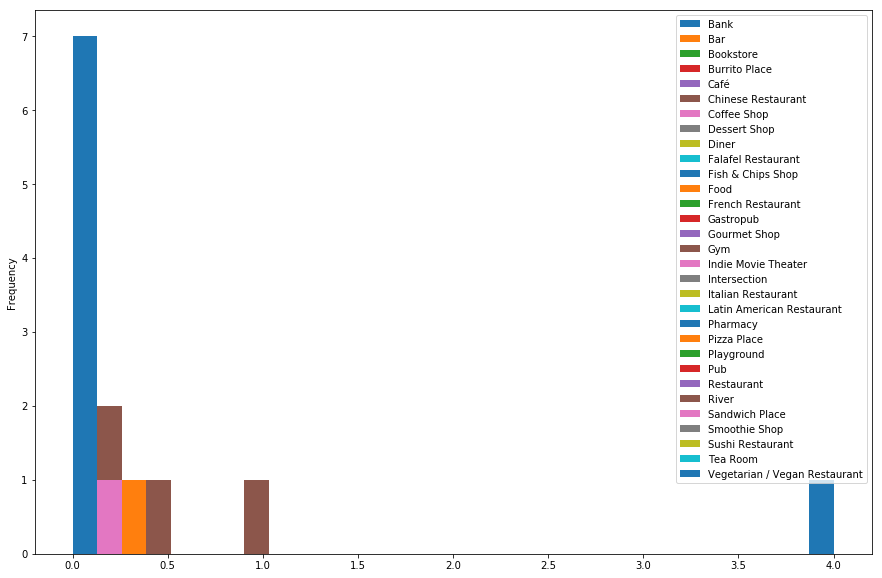

In [277]:
uk_stats.plot.hist(bins=uk_stats.shape[1], figsize=(15,10))
plt.legend(loc='upper right')
plt.show()

### Report venue frequency per neighbourhood with the highest population of Ukrainians

                venue  freq
0                Café  0.09
1         Coffee Shop  0.09
2         Pizza Place  0.09
3    Sushi Restaurant  0.06
4  Italian Restaurant  0.06


                 venue  freq
0                River   1.0
1                 Bank   0.0
2  Indie Movie Theater   0.0
3             Tea Room   0.0
4     Sushi Restaurant   0.0


                 venue  freq
0                 Bank   1.0
1  Indie Movie Theater   0.0
2             Tea Room   0.0
3     Sushi Restaurant   0.0
4        Smoothie Shop   0.0


                venue  freq
0         Pizza Place  0.29
1        Intersection  0.14
2  Chinese Restaurant  0.14
3         Coffee Shop  0.14
4      Sandwich Place  0.14




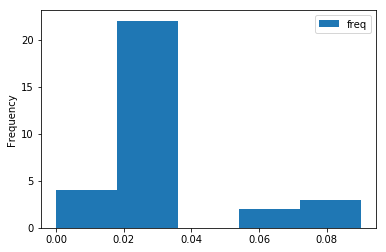

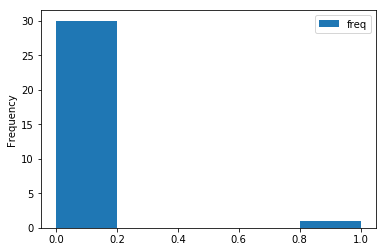

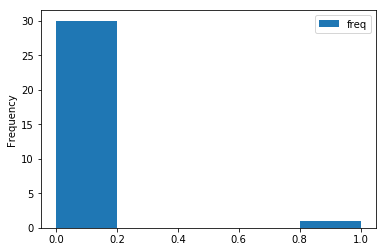

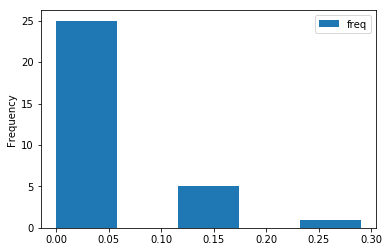

In [266]:
num_top_venues = 5

for hood in uk_grouped['Neighborhood']:
    temp = uk_grouped[uk_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp.plot.hist(bins=5)
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


In [119]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def return_least_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### List least common venues - Lowest venue frequncy presents the highest returns for business with the least amount of competition

In [128]:
num_least_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of bottom venues
columns = ['Neighborhood']
for ind in np.arange(num_least_venues):
    try:
        columns.append('{}{} Least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = uk_grouped['Neighborhood']

for ind in np.arange(uk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_least_common_venues(uk_grouped.iloc[ind, :], num_least_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,Runnymede,River,Chinese Restaurant,Playground,Intersection,Bank,Smoothie Shop,Sandwich Place,Restaurant,Pub,Pharmacy
1,The Kingsway,Bank,Sushi Restaurant,Smoothie Shop,Sandwich Place,Restaurant,Pub,Playground,Pizza Place,Pharmacy,Latin American Restaurant
2,West Deane Park,Gym,Sushi Restaurant,Smoothie Shop,Sandwich Place,River,Restaurant,Pub,Playground,Pizza Place,Pharmacy
3,Westmount,Bank,Sushi Restaurant,Smoothie Shop,River,Restaurant,Pub,Pharmacy,Latin American Restaurant,Italian Restaurant,Indie Movie Theater


### Perform Neighbourhood Cluster Analysis

In [130]:
# set number of clusters
kclusters = 4

uk_grouped_clustering = uk_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(uk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 1, 3], dtype=int32)

### Merge the results with the clusters

In [131]:
df_uk_merged = df_uk

# add clustering labels
df_uk_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_uk_merged = df_uk_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

df_uk_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
49,M9P,Etobicoke,Westmount,43.696319,-79.532242,5857,5932,35183,10.6,Ukrainian,0,Bank,Sushi Restaurant,Smoothie Shop,River,Restaurant,Pub,Pharmacy,Latin American Restaurant,Italian Restaurant,Indie Movie Theater
8,M9B,Etobicoke,West Deane Park,43.650943,-79.554724,4395,2063,41582,02.3,Ukrainian,2,Gym,Sushi Restaurant,Smoothie Shop,Sandwich Place,River,Restaurant,Pub,Playground,Pizza Place,Pharmacy
59,M6S,West Toronto,Runnymede,43.651571,-79.484450,4382,5155,42635,02.2,Ukrainian,1,River,Chinese Restaurant,Playground,Intersection,Bank,Smoothie Shop,Sandwich Place,Restaurant,Pub,Pharmacy
74,M8X,Etobicoke,The Kingsway,43.653654,-79.506944,8780,3403,110944,01.8,Ukrainian,3,Bank,Sushi Restaurant,Smoothie Shop,Sandwich Place,Restaurant,Pub,Playground,Pizza Place,Pharmacy,Latin American Restaurant


### Draw a map of the location most suitable for opening a new business venture targeting the demographic with the highest population of Ukrainians

In [135]:
# create map
map_clusters = folium.Map(location=[T_lat, T_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_uk_merged['Latitude'], df_uk_merged['Longitude'], df_uk_merged['Neighbourhood'], df_uk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Suggest the following business ventures based on the lowest frequncy of venues in the 1st cluster

In [138]:
df_uk_merged.loc[df_uk_merged['Cluster Labels'] == 0, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]

,Borough,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
49,Etobicoke,5857,5932,35183,10.6,Ukrainian,0,Bank,Sushi Restaurant,Smoothie Shop,River,Restaurant,Pub,Pharmacy,Latin American Restaurant,Italian Restaurant,Indie Movie Theater


### Suggest the following business ventures based on the lowest frequncy of venues in the 2nd cluster

In [139]:
df_uk_merged.loc[df_uk_merged['Cluster Labels'] == 1, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]

,Borough,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
59,West Toronto,4382,5155,42635,02.2,Ukrainian,1,River,Chinese Restaurant,Playground,Intersection,Bank,Smoothie Shop,Sandwich Place,Restaurant,Pub,Pharmacy


### Suggest the following business ventures based on the lowest frequncy of venues in the 3rd cluster

In [140]:
df_uk_merged.loc[df_uk_merged['Cluster Labels'] == 2, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]

,Borough,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
8,Etobicoke,4395,2063,41582,02.3,Ukrainian,2,Gym,Sushi Restaurant,Smoothie Shop,Sandwich Place,River,Restaurant,Pub,Playground,Pizza Place,Pharmacy


### Suggest the following business ventures based on the lowest frequncy of venues in the 4th cluster

In [141]:
df_uk_merged.loc[df_uk_merged['Cluster Labels'] == 3, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]

,Borough,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
74,Etobicoke,8780,3403,110944,01.8,Ukrainian,3,Bank,Sushi Restaurant,Smoothie Shop,Sandwich Place,Restaurant,Pub,Playground,Pizza Place,Pharmacy,Latin American Restaurant


## Recommendation Report: We recommend the following venues targeting the Ukrainian demographic

### Locations

In [142]:
# create map
map_clusters = folium.Map(location=[T_lat, T_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_uk_merged['Latitude'], df_uk_merged['Longitude'], df_uk_merged['Neighbourhood'], df_uk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### List of recommended venues per each cluster

In [227]:
dict_suggested_venues = {}
for x in range(0, kclusters):
    df = df_uk_merged.loc[df_uk_merged['Cluster Labels'] == x, df_uk_merged.columns[[1,2]]]
    label = df.values[0][0] + '-' + df.values[0][1]
    df1 = df_uk_merged.loc[df_uk_merged['Cluster Labels'] == x, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]
    dict_suggested_venues[label] = df1.values[0][7:]
    
rec_df = pd.DataFrame.from_dict(dict_suggested_venues, orient='index')
dict_rename_cols = {}
for i in range(0, 10):
    dict_rename_cols[i] = 'Venue {}'.format(i)
rec_df = rec_df.rename(columns=dict_rename_cols)
rec_df

{0: 'Venue 0', 1: 'Venue 1', 2: 'Venue 2', 3: 'Venue 3', 4: 'Venue 4', 5: 'Venue 5', 6: 'Venue 6', 7: 'Venue 7', 8: 'Venue 8', 9: 'Venue 9'}


,Venue 0,Venue 1,Venue 2,Venue 3,Venue 4,Venue 5,Venue 6,Venue 7,Venue 8,Venue 9
Etobicoke-The Kingsway,Bank,Sushi Restaurant,Smoothie Shop,Sandwich Place,Restaurant,Pub,Playground,Pizza Place,Pharmacy,Latin American Restaurant
Etobicoke-Westmount,Bank,Sushi Restaurant,Smoothie Shop,River,Restaurant,Pub,Pharmacy,Latin American Restaurant,Italian Restaurant,Indie Movie Theater
Etobicoke-West Deane Park,Gym,Sushi Restaurant,Smoothie Shop,Sandwich Place,River,Restaurant,Pub,Playground,Pizza Place,Pharmacy
West Toronto-Runnymede,River,Chinese Restaurant,Playground,Intersection,Bank,Smoothie Shop,Sandwich Place,Restaurant,Pub,Pharmacy


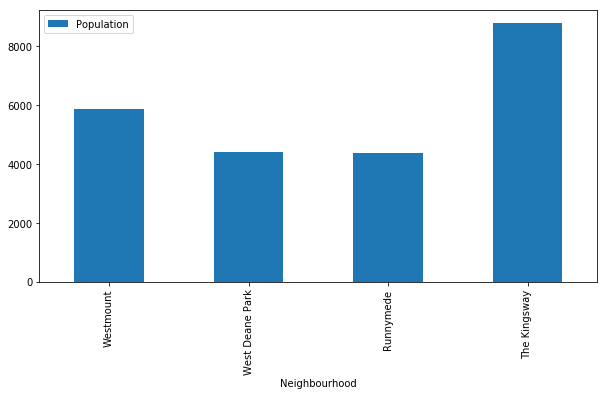

In [284]:
df_pop = df_uk[['Population', 'Neighbourhood']]
df_pop = df_pop.set_index('Neighbourhood')
df_pop.plot.bar(figsize=(10,5))
plt.show()

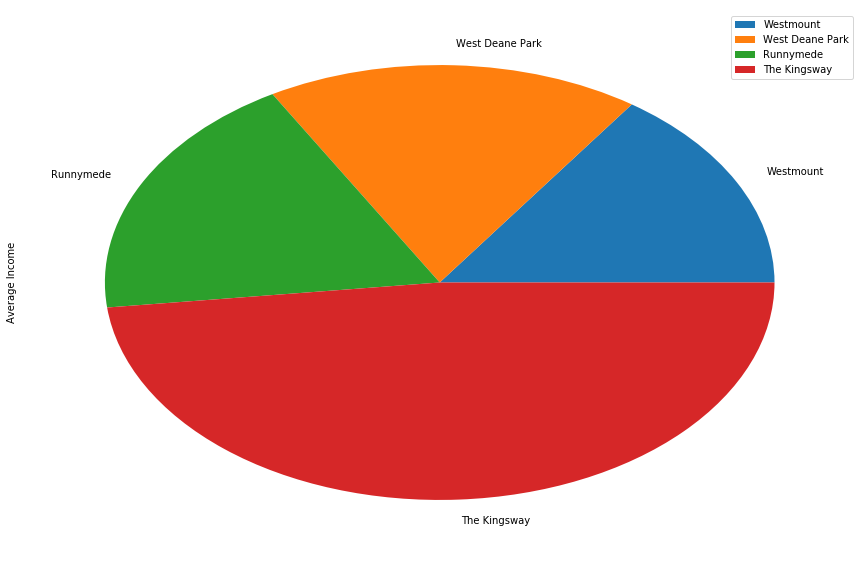

In [278]:
df_inc = df_uk[['Average Income', 'Neighbourhood']]
df_inc = df_inc.set_index('Neighbourhood')
df_inc = df_inc.apply(pd.to_numeric, errors='ignore')
df_inc.plot.pie(subplots=True, figsize=(15, 10))
plt.legend(loc='upper right')
plt.show()


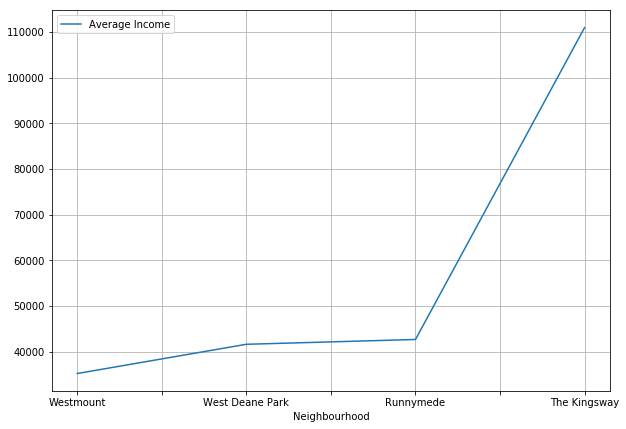

In [280]:
df_inc = df_uk[['Average Income', 'Neighbourhood']]
df_inc = df_inc.set_index('Neighbourhood')
df_inc = df_inc.apply(pd.to_numeric, errors='ignore')
df_inc.plot(grid=True, figsize=(10,7))

# Thank you for reviwing my work!